In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, TimeDistributed, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

In [3]:
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
CLASS = [
    "normal",
    "AF"
]

SAMPLES_PER_PERSON = 5000

NUM_CLASSES = len(CLASS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for ecg_index in range(NUM_CLASSES):
  ecg = CLASS[ecg_index]
  print(f"Processing index {ecg_index} for ECG : '{ecg}'.")

  output = ONE_HOT_ENCODED_CLASSES[ecg_index]

  # Construct the file path for the current ECG class
  file_path = f"/content/drive/MyDrive/Final_{ecg}_data.csv"  #D:\Varsity\Thesis\ECG dataset\Physionet

  df = pd.read_csv(file_path)

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_PERSON)
  print(df.shape[0])
  print(f"\tThere are {num_recordings} recordings of the {ecg} ECG.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_PERSON):
      index = i * SAMPLES_PER_PERSON + j
      # normalize the input data, between 0 to 1:

      tensor += [
          df['ECG1'][index],
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
print(inputs.shape)
print(outputs.shape)
#print(inputs)
#print(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for ECG : 'normal'.
130560
	There are 26 recordings of the normal ECG.
Processing index 1 for ECG : 'AF'.
345000
	There are 69 recordings of the AF ECG.
(95, 5000)
(95, 2)
Data set parsing and preparation complete.


In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087


num_inputs = len(inputs)
print(num_inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]


# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
Y_train, Y_test, Y_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(inputs_train.shape)
print(inputs_validate.shape)
print(inputs_test.shape)


print("Data set randomization and splitting complete.")

95
(57, 5000)
(19, 5000)
(19, 5000)
Data set randomization and splitting complete.


In [5]:
window_size = 250
segment_no = 20

print(inputs_train.shape)
print(inputs_test.shape)
print(inputs_validate.shape)

X_train = np.reshape(inputs_train, (-1, segment_no, window_size))
X_test = np.reshape(inputs_test, (-1, segment_no, window_size))
X_validate = np.reshape(inputs_validate, (-1, segment_no, window_size))

#print(inputs_train.shape)
#print(inputs_train[0][0][0])
#print(len(inputs_train[0][0]))
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)



#print(inputs_train)

(57, 5000)
(19, 5000)
(19, 5000)
(57, 20, 250)
(19, 20, 250)
(19, 20, 250)


In [6]:
# Flatten the 2D features to 1D
num_features = X_train.shape[-1]
num_samples = X_train.shape[0]
inputs_train = X_train.reshape(-1, num_features)
outputs_train = Y_train.repeat(20, axis=0)  # Repeat the labels for each array


# Similarly preprocess validation and test data
inputs_validate = X_validate.reshape(-1, num_features)
outputs_validate = Y_validate.repeat(20, axis=0)
inputs_test = X_test.reshape(-1, num_features)
outputs_test = Y_test.repeat(20, axis=0)

print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)


inputs_train = inputs_train.reshape((1140, 250, 1))
inputs_validate = inputs_validate.reshape((380, 250, 1))
inputs_test = inputs_test.reshape((380, 250, 1))



print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)

(1140, 250)
(1140, 2)
(380, 250)
(380, 2)
(380, 250)
(380, 2)
(1140, 250, 1)
(1140, 2)
(380, 250, 1)
(380, 2)
(380, 250, 1)
(380, 2)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the inverted residual block
def inverted_residual_block(x, expansion, stride, filters):
    # Expansion Layer
    in_channels = x.shape[-1]
    x = layers.Conv1D(expansion * in_channels, kernel_size=1, activation='relu')(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv1D(kernel_size=3, strides=stride, padding='same', activation='relu')(x)

    # Projection Layer
    x = layers.Conv1D(filters, kernel_size=1, activation=None)(x)

    # Add skip connection if the input and output shapes are the same
    if stride == 1 and in_channels == filters:
        x = layers.add([x, inputs])

    return x

# Define MobileNetV2 model with specified architecture
def MobileNetV2(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Stem Convolution
    x = layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)

    # Inverted Residual Blocks
    x = inverted_residual_block(x, expansion=6, stride=1, filters=8)
    x = inverted_residual_block(x, expansion=6, stride=2, filters=12)
    x = inverted_residual_block(x, expansion=6, stride=2, filters=16)
    x = inverted_residual_block(x, expansion=6, stride=2, filters=24)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layer
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs, x)

    return model

# Specify input shape and number of classes
input_shape = (250, 1)  # Update with your actual input shape
num_classes = 2  # Update with the number of classes for your classification task

# Create the MobileNetV2 model
model = MobileNetV2(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 125, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 192)          6336      
                                                                 
 depthwise_conv1d (Depthwis  (None, 125, 192)          768       
 eConv1D)                                                        
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 8)            1544      
                                                                 
 conv1d_3 (Conv1D)           (None, 125, 48)           432       
                                                             

In [8]:
# Step 1: Data Preparation
# Load and preprocess your ECG dataset here (e.g., PhysioNet Challenge 2017 dataset)
# Split the data into training, validation, and test sets

# Step 2: Data Preprocessing
# Normalize the data
# One-hot encode labels if necessary
# Create data generators or data loaders for efficient training

# Step 3: Model Training Configuration
num_epochs = 100  # Adjust as needed
batch_size = 10  # Adjust as needed
learning_rate = 0.00001  # Adjust as needed
checkpoint_path = 'model_checkpoint.h5'  # Path to save model checkpoints



optim = tf.optimizers.Adam(learning_rate = learning_rate)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10, min_lr=1e-6, verbose=1)

checkpoint_filepath = os.path.join(r"/content/drive/MyDrive", 'resnet_model.h5')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(inputs_train, outputs_train, validation_data =(inputs_validate, outputs_validate),
          epochs = num_epochs, batch_size = batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])




Epoch 1/100
113/114 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.7168
Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to /content/drive/MyDrive/resnet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 6s 22ms/step - loss: 0.6203 - accuracy: 0.7175 - val_loss: 0.6240 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 2/100
113/114 [============================>.] - ETA: 0s - loss: 0.5952 - accuracy: 0.7195
Epoch 2: val_accuracy did not improve from 0.68421
114/114 [==============================] - 3s 22ms/step - loss: 0.5953 - accuracy: 0.7193 - val_loss: 0.6237 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7509
Epoch 3: val_accuracy improved from 0.68421 to 0.80263, saving model to /content/drive/MyDrive/resnet_model.h5
114/114 [==============================] - 2s 19ms/step - loss: 0.5190 - accuracy: 0.7509 - val_loss: 0.4283 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 4/100
112/114 [============================>.] - ETA: 0s - loss: 0.3463 - accuracy: 0.8446
Epoch 4: val_accuracy improved from 0.80263 to 0.85789, saving model to /content/drive/MyDrive/resnet_model.h5
1

In [15]:
# Step 5: Evaluation
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 0s 17ms/step - loss: 0.0147 - accuracy: 0.9947
Test Loss: 0.014746774919331074
Test Accuracy: 0.9947368502616882


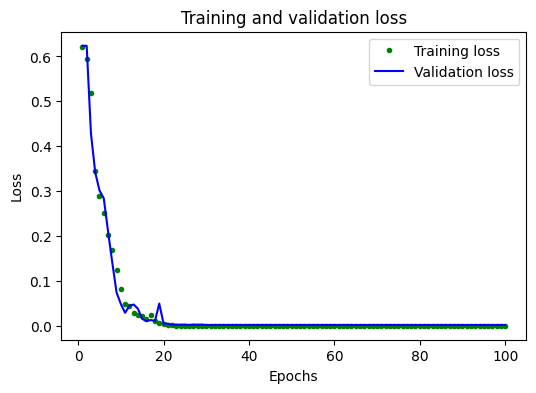

[6.0, 4.0]


In [16]:

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [17]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
y_true = outputs_test
y_pred = predictions


12/12 [==============================] - 0s 14ms/step
predictions =
 [[0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.001 0.999]
 [0.912 0.106]
 [0.003 0.997]
 [0.001 0.999]
 [0.003 0.997]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 

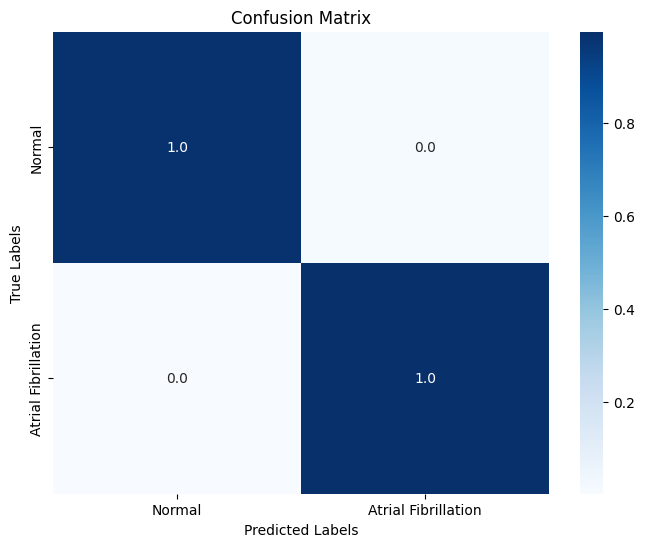

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(outputs_test.argmax(axis=1), predictions.argmax(axis=1))
# Normalize the confusion matrix to show percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_names = ["Normal", "Atrial Fibrillation"]

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report

classification_rep = classification_report(outputs_test.argmax(axis=1), predictions.argmax(axis=1))
print(classification_rep)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       1.00      1.00      1.00       300

    accuracy                           0.99       380
   macro avg       0.99      0.99      0.99       380
weighted avg       0.99      0.99      0.99       380



In [20]:
from sklearn.metrics import recall_score

recall = recall_score(outputs_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
print(f"Recall: {recall}")


Recall: 0.9947368421052631
